# Classical Control Tutorial: Quantum Fourier Transform (QFT)
In this tutorial we will explore implementing classical conditioning gates into the Quantum Fourier Transform (QFT).
Starting with the simplest version of QFT, we will show how `TKET` can be utilised to replace all two qubit gates within the QFT with measurements and classical controls, in addition to using ancillae to formulate a fault-tolerant QFT that uses less $T$ gates than standard approaches.

## Textbook QFT
In this section we give a brief summary of the QFT, and implement the textbook QFT formulation using `TKET`.
The QFT is a vital subroutine in many important quantum algorithms including Shor's factoring algorithm, solving linear systems of equations (HHL), phase estimation _etc_. .
In essence, the QFT is a quantum formulation of the discrete Fourier transform, and is equivalent up to a constant when the input data has a size that is a power of 2.
Acting on a bitstring state, $|x_1 x_2, ..., x_n\rangle $ where $x_i \in \{0,1\}$ the QFT can be mathematically described as follows,
\begin{equation}
\text{QFT} |x_1 x_2, ..., x_n\rangle = \frac{1}{\sqrt{N}} 
\left( |0\rangle + e^{2 \pi i 0.x_{1} x_{2} ... x_{n}}|1\rangle \right) \otimes 
\left( |0\rangle + e^{2 \pi i 0.x_{2} x_{3} ... x_{n}}|1\rangle \right) \otimes
... \otimes
\left( |0\rangle + e^{2 \pi i 0.x_n}|1\rangle \right)
\end{equation}
where $N = 2^n$ and $0.x_i x_{i+1} ... x_n $ is a fractional binary notation given by, $0.x_i x_{i+1} ... x_n = x_i / 2 + x_{i+1} / 4 + ... + x_n / 2^{n-i + 1}$.

### Import packages

The packages relevant to this tutorial are imported.
Note that every QFT implementation is strictly done using `pytket` and the `pytket-qiskit` extension.

In [1]:
from pytket import Circuit, OpType
from pytket.extensions.qiskit import AerBackend, AerUnitaryBackend
from pytket.circuit import CircBox, StatePreparationBox, Qubit, Bit
from pytket.circuit.display import render_circuit_jupyter
from qiskit.providers.aer.noise import NoiseModel

import numpy as np
import matplotlib.pyplot as plt

### Construct circuit
Constructing the textbook QFT circuit is fairly intuitive using the equation above.
We can see that the state of each qubit in the bitstring, $|x_i \rangle$, is transformed into a superposition of the computational basis states, $\{|0\rangle, |1\rangle \}$, and a phase is conditionally added to the $|1\rangle$ state depending on $x_i$.

Note that in the above equation we have chosen to omit the swap operations for simplicity, however to obtain an equivalent transformation to the discrete Fourier transform the qubits are readout in a reversed order, which can be done either in classical post-processing or on the quantum device through use of swap gates.

With this in mind, the textbook QFT circuit is constructed as follows:

In [2]:
def create_qft_circuit(n, do_swaps=False):
    circ = Circuit(n, name="QFT")
    for i in range(n):
        circ.H(i)
        for j in range(i + 1, n):
            circ.CU1(1 / 2 ** (j - i), i, j)
        circ.add_barrier(range(n))
    if do_swaps:
        for i in range(n // 2):
            circ.SWAP(i, n - i - 1)
    return circ

The ordering of the target and control qubits in the controlled U1 operations may look different to those familiar with QFT. 
However, a simple exercise will show that the two representations are equivalent --- we choose this representation in particular as it will translate more smoothly into semi-classical QFT later on.

In [3]:
n = 7
naive_qft = create_qft_circuit(n, True)
render_circuit_jupyter(naive_qft)

### Gaussian
We benchmark the different QFT formulations by performing a Fourier transform of a Gaussian function.
Since the analytic form for the Fourier transformed Gaussian is well known, this will give us a good base to compare the different formulations to. 
Here, we define the theoretical forms for the Gaussian and Fourier transformed Gaussian.

In [4]:
def gaussian_state(n, sigma=0.1):
    x = np.linspace(-1, 1, num=2**n)
    gaussian = np.exp(-0.5 * (x / sigma) ** 2)
    return gaussian / np.linalg.norm(gaussian)


def fourier_gaussian_state(n, sigma=0.1):
    x = np.linspace(-1, 1, num=2**n)
    k = np.fft.fftfreq(2**n, x[1] - x[0])
    fourier_gaussian = np.exp(-0.5 * (2 * np.pi * sigma * k) ** 2)
    return fourier_gaussian / np.linalg.norm(fourier_gaussian)

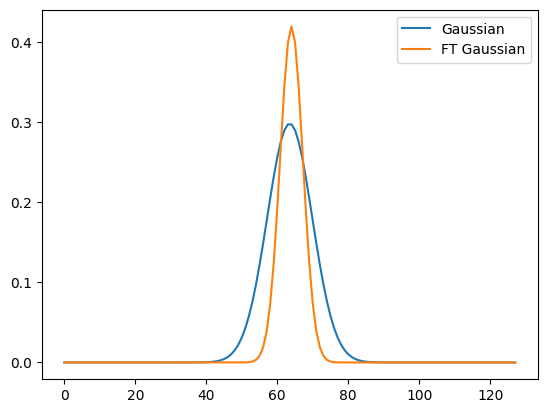

In [5]:
psi_gaussian = gaussian_state(n)
psi_qft_gaussian = fourier_gaussian_state(n)
plt.plot(psi_gaussian, label="Gaussian")
plt.plot(np.fft.fftshift(psi_qft_gaussian), label="FT Gaussian")
plt.legend()

### Naive QFT Gaussian Circuit
The textbook QFT circuit for the Fourier transformed Gaussian is constructed.
This requires creating and appending a state preparation box that prepares the input state in the appropiate Gaussian form.

In [6]:
def create_stateprep_box(n):
    psi_gaussian = gaussian_state(n)
    return StatePreparationBox(psi_gaussian)

In [7]:
naive_qft_gaussian_circ = Circuit(n, n)

# Add state preparation to start of circuit
naive_qft_gaussian_circ.add_state_preparation_box(create_stateprep_box(n), range(n))

# Add naive QFT as a CircBox
naive_QFT_circ_box = CircBox(naive_qft)
naive_qft_gaussian_circ.add_circbox(naive_QFT_circ_box, range(n))

# Add measurements to end of circuit
naive_qft_gaussian_circ.measure_all()

render_circuit_jupyter(naive_qft_gaussian_circ)

Counts from the sampling of the circuit above are converted into a state vector using the same function as the previous tutorial.

In [8]:
def from_counts_to_array(counts, n):
    bitstrings = [format(i, f"0{n}b") for i in range(2**n)]
    counts_strings = [
        f"{i}".replace(",", "").replace("(", "").replace(")", "").replace(" ", "")
        for i in counts.keys()
    ]
    counts_values = list(counts.values())
    arr = [
        sum(
            [
                k / sum(counts_values) if i == j else 0
                for i, k in zip(counts_strings, counts_values)
            ]
        )
        for j in bitstrings
    ]
    return arr

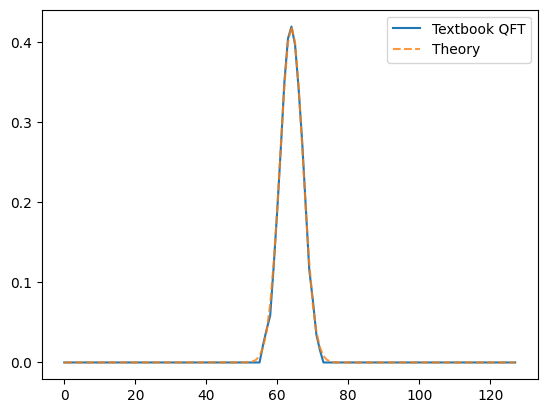

In [9]:
backend = AerBackend()
naive_compiled_circ = backend.get_compiled_circuit(naive_qft_gaussian_circ)

naive_handle = backend.process_circuit(naive_compiled_circ, n_shots=2**12)
naive_counts = backend.get_result(naive_handle).get_counts()

naive_psi = from_counts_to_array(naive_counts, n)
plt.plot(
    np.fft.fftshift(np.sqrt(naive_psi)), label="Textbook QFT"
)  # Need to take square root, since measurements obtain amp. squared.
plt.plot(np.fft.fftshift(psi_qft_gaussian), label="Theory", ls="--", alpha=0.8)
plt.legend()

## Semi-classical QFT
In this section we explain how semi-classical QFT can be implemented in `TKET`, which requires the use of classic logical operations.
Semi-classical QFT replaces the two-qubit conditional gates with measurements, thus removing all two-qubit gates (excluding swap gates) from the circuit.
Instead, the phase on the qubits is applied depending on the outcome of the measurement, more details about this formulation can be found [here](https://arxiv.org/pdf/quant-ph/9511007.pdf) and a practial implementation can be found [here](https://arxiv.org/pdf/quant-ph/9511007.pdf).

This formulation can be extremely desirable in situations where two-qubit gate error is high.
However, since measurements of the target qubits are taken this approach is only applicable when the measurement outcomes are required straight after the semi-classical QFT.
In other words, the semi-classical QFT is equivalent to QFT + measurement, _not_ solely QFT.

### Construct circuit
As mentioned above, transformations are applied onto the target qubit before being measured.
The measurement outcome is then used to determine whether a phase is applied onto the qubit below.

This type of classical conditioning can be easily implemented in `TKET` by using the `condition_bits` and `condition_value` keyword arguements in the gate method.
The `condition_bits` kwargs tells us which classical bit to base the conditioning on, whilst the `condition_value` kwargs tells us what classical value dictates an application _e.g._ if 1 is measured in the computational basis.

In [10]:
def construct_semiclassical_qft_circuit(n, do_swaps=False):
    circ = Circuit(n, n, name="SC QFT")

    for i in range(n):
        circ.H(i)
        circ.Measure(i, i)
        for j in range(i + 1, n):
            circ.U1(1 / 2 ** (j - i), j, condition_bits=[i], condition_value=1)
        circ.add_barrier(range(n))
    if do_swaps:
        for i in range(n // 2):
            circ.SWAP(i, n - i - 1)

    return circ


semiclassical_qft = construct_semiclassical_qft_circuit(n)
render_circuit_jupyter(semiclassical_qft)

### Semiclassical QFT Gaussian Circuit
The semi-classical QFT circuit for the Gaussian is constructed.
Since this formulation already contains measurements, we don't need to include anymore measurements at the end of the circuit.

In [11]:
semi_classical_qft_gaussian_circ = Circuit(n)

# Add classical bits.
for i in range(n):
    semi_classical_qft_gaussian_circ.add_c_register(f"c{i}", 1)

# Add state preparation to start of circuit
semi_classical_qft_gaussian_circ.add_state_preparation_box(
    create_stateprep_box(n), range(n)
)

# Add naive QFT as a CircBox
semiclassical_QFT_circ_box = CircBox(semiclassical_qft)
semi_classical_qft_gaussian_circ.add_circbox(
    semiclassical_QFT_circ_box,
    [*[Qubit(i) for i in range(n)], *[Bit(f"c{i}", 0) for i in range(n)]],
)

render_circuit_jupyter(semi_classical_qft_gaussian_circ)

Since measuring the target qubits immediately after applying operations to them is required for the computation, the swap operations must be done after the quantum circuit is applied.
This can be done by reading out the qubits in a reverse order, or applying the swap operations in post-processing.

In [12]:
def swaps(n):
    circ = Circuit(n)
    for i in range(n // 2):
        circ.SWAP(i, n - i - 1)
    backend = AerUnitaryBackend()
    compiled_circ = backend.get_compiled_circuit(circ)
    return backend.run_circuit(compiled_circ).get_unitary().real


U_swap = swaps(n)

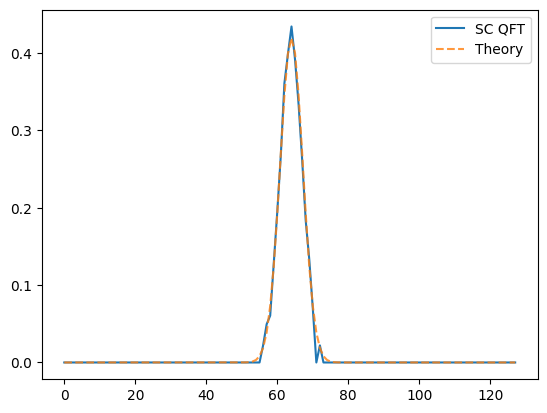

In [13]:
backend = AerBackend()
semiclassical_compiled_circ = backend.get_compiled_circuit(
    semi_classical_qft_gaussian_circ
)

semiclassical_handle = backend.process_circuit(
    semiclassical_compiled_circ, n_shots=2**12
)
semiclassical_counts = backend.get_result(semiclassical_handle).get_counts()

semiclassical_psi = from_counts_to_array(semiclassical_counts, n)
plt.plot(np.fft.fftshift(np.sqrt(U_swap @ semiclassical_psi)), label="SC QFT")
plt.plot(np.fft.fftshift(psi_qft_gaussian), label="Theory", ls="--", alpha=0.8)
plt.legend()

## Ancilla Assisted QFT
In this section we implement Ancilla Assisted (AA) QFT, which uses intermediate measurements on ancillae qubits to produce a QFT formulation that is more efficent in the fault-tolerant regime.
AA QFT using additional qubits to synthesis gates that are more efficent in a fault-tolerant gateset, such as $\{\text{T} + \text{Clifford}\}$.
In other words, AA QFT has a lower number of T gates, but a higher number of CNOT gates which are less costly to synthesis in a fault-tolerant regime than T gates.

A detailed description of AA QFT, including gate counts for different numbers of qubits and further efficent decompositions of the AA QFT circuit by use of addition subroutines can be found [here](https://www.nature.com/articles/s41534-020-0257-5).

Note that we are using this QFT formulation as an example of intermediate measurements within a quantum circuit, and will not be focusing on T counts in this tutorial.

### Construct circuit
AA QFT requires replacing the controlled phase rotations (controlled U1 gates) with a gadget containing the target and control qubit, alongside a single ancilla.
The use of these gadgets allow the single qubit operations acting on the ancillae to be collected into a single layer, which are then implemented in paralell _via_ a phase gradient operation which uses an addition circuit.
By using repeat-until-success circuits for the addition circuit, one could argue that this QFT formulation has an additional robustness to noise. 

In this tutorial we will simply focus on implementing this target, control + ancilla gadget and implement the single qubit operations on the ancillae separately _i.e._ without the phase gradient operation/ addition circuits. 

#### Single target qubit

The construction of this circuit is taken directly from [here](https://www.nature.com/articles/s41534-020-0257-5), where the use of an ancilla allows the controlled U1($\theta$) gate to be decomposed into a Toffoli, controlled Z and single qubit gates including a (non-controlled) U1($\theta$) gate.
The controlled Z gate is both "quantumly" conditioned on the top qubit, and classically conditioned on the measurement outcome of the ancilla qubit.
We also include a reset gate to ensure the circuit outputs the same result everytime, given the same input.

In [14]:
def pytket_ancilla_assisted_cp(a):
    qc = Circuit(3, 1, name="aa_cp")
    qc.CCX(*range(3))
    qc.U1(1 / a, 2)
    qc.H(2)
    qc.Measure(2, 0)
    qc.CZ(0, 1, condition_bits=[0], condition_value=1)
    qc.add_gate(OpType.Reset, [2])

    return qc


qc = pytket_ancilla_assisted_cp(4)
render_circuit_jupyter(qc)

#### Multi target qubits
This gadget can be applied to multiple target qubits conditioned upon the same control qubit.
We choose the angle applied to each target qubit to be the same angles found in the textbook QFT.

In [15]:
def ancilla_assisted_multi_cp(n):
    qc = Circuit(name="aa_mcp")
    qc.add_q_register("t", n)  # Target qubit register
    qc.add_q_register("a", n - 1)  # Ancillae qubit register
    qc.add_c_register("c", n - 1)  # Classical bit register

    for q in range(n - 1):
        ctrl_phase_box = CircBox(pytket_ancilla_assisted_cp(2 ** (q + 1)))
        qc.add_circbox(
            ctrl_phase_box,
            args=[Qubit("t", 0), Qubit("t", q + 1), Qubit("a", q), Bit("c", q)],
        )  # Control, target, ancilla, classical

    return qc


qc = ancilla_assisted_multi_cp(3)
render_circuit_jupyter(qc)

### AA QFT Gaussian circuit
Construct the AA QFT circuit by replacing the controlled phase rotations with the gadgets shown above.
Since we are using this circuit to Fourier transform a Gaussian, we also include the state preparation circuit as well.

In [16]:
def ancilla_assisted_qft(n, do_swaps=True, state_prep=False):
    qc = Circuit()
    qc.add_q_register("t", n)
    qc.add_q_register("a", n - 1)
    for i in range(n):
        qc.add_c_register(f"c{i}", 1)

    if state_prep:
        qc.add_state_preparation_box(
            create_stateprep_box(n), args=[Qubit("t", i) for i in range(n)]
        )

    for i in range(n):

        qc.H(Qubit("t", i))
        # multi_ctrl_phase_box --- Circ box doens't allow for circs w/ more than one regiser
        for q in range(n - i - 1):
            ctrl_phase_box = CircBox(pytket_ancilla_assisted_cp(2 ** (q + 1)))
            qc.add_circbox(
                ctrl_phase_box,
                args=[
                    Qubit("t", i),
                    Qubit("t", q + 1 + i),
                    Qubit("a", q),
                    Bit(f"c{q}", 0),
                ],
            )  # Control, target, ancilla, classical
        qc.add_barrier(
            [Qubit("t", i) for i in range(n)] + [Qubit("a", i) for i in range(n - 1)]
        )

    if do_swaps:
        for i in range(n // 2):
            qc.SWAP(Qubit("t", i), Qubit("t", n - i - 1))

    for i in range(n):
        qc.Measure(Qubit("t", i), Bit(f"c{i}", 0))
    return qc


aa_qft_gaussian_circ = ancilla_assisted_qft(n, do_swaps=True, state_prep=True)
render_circuit_jupyter(aa_qft_gaussian_circ)

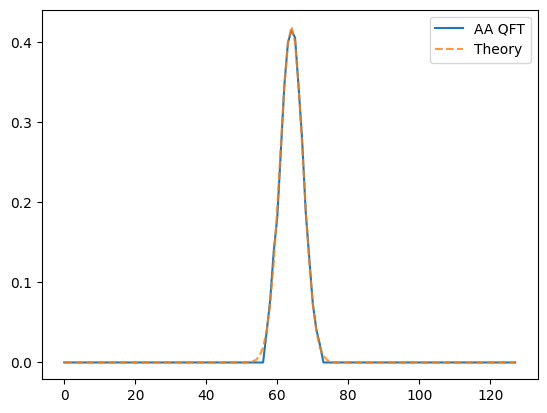

In [17]:
backend = AerBackend()
aa_compiled_circ = backend.get_compiled_circuit(aa_qft_gaussian_circ)

aa_handle = backend.process_circuit(aa_compiled_circ, n_shots=2**12)
aa_counts = backend.get_result(aa_handle).get_counts()

aa_psi = from_counts_to_array(aa_counts, n)
plt.plot(np.fft.fftshift(np.sqrt(aa_psi)), label="AA QFT")
plt.plot(np.fft.fftshift(psi_qft_gaussian), label="Theory", ls="--", alpha=0.8)
plt.legend()

## Comparison of Implementions
In this section we compare the results of the different QFT formulations for the Fourier transformed Gaussian using the measurement error noise model.
Note that this is not a fair comparison, since each QFT formulation has it's own strengths and weaknesses outside of noise robustness --- we simply use this opportunity to explore the effect of noise on intermediate measurements using `TKET`.

### Create noise model
As mentioned above, we create a simple noise model with a 10% chance that upon measurement a qubit that should have been measured as 0, would instead be measured as 1, and vice versa.

In [18]:
readout_noise_model = NoiseModel()
readout_error = 0.1
for q in range(n):
    readout_noise_model.add_readout_error(
        [[1 - readout_error, readout_error], [readout_error, 1 - readout_error]], [q]
    )

noisy_backend = AerBackend(readout_noise_model)

We require a different noisy model for AA QFT since it has a different number of qubits, even though only the target qubits are measured.

In [19]:
AA_readout_noise_model = NoiseModel()
for q in range(2 * n - 1):
    AA_readout_noise_model.add_readout_error(
        [[1 - readout_error, readout_error], [readout_error, 1 - readout_error]], [q]
    )

AA_noisy_backend = AerBackend(AA_readout_noise_model)

### Run noisy simulations
Run different QFT implementations with readout noise model.

In [20]:
shots = 2**12

# Textbook QFT
noisy_naive_compiled_circ = noisy_backend.get_compiled_circuit(naive_qft_gaussian_circ)
noisy_naive_handle = noisy_backend.process_circuit(
    noisy_naive_compiled_circ, n_shots=shots
)
noisy_naive_counts = noisy_backend.get_result(noisy_naive_handle).get_counts()

# Semi-classical QFT
noisy_sc_compiled_circ = noisy_backend.get_compiled_circuit(
    semi_classical_qft_gaussian_circ
)
noisy_sc_handle = noisy_backend.process_circuit(noisy_sc_compiled_circ, n_shots=shots)
noisy_sc_counts = noisy_backend.get_result(noisy_sc_handle).get_counts()

# AA QFT
noisy_aa_compiled_circ = AA_noisy_backend.get_compiled_circuit(aa_qft_gaussian_circ)
noisy_aa_handle = AA_noisy_backend.process_circuit(
    noisy_aa_compiled_circ, n_shots=shots
)
noisy_aa_counts = AA_noisy_backend.get_result(noisy_aa_handle).get_counts()

### Plot noisy results
Plot results for noisy simulations.
As we can see, semi-classical QFT performs poorly, whilst textbook QFT and AA QFT perform roughly the same.
This is due to the knock-on effect on measurement error within the semi-classical QFT circuit.

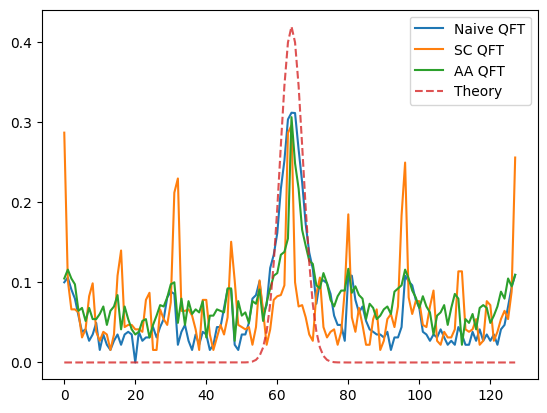

In [21]:
noisy_naive_psi = from_counts_to_array(noisy_naive_counts, n)
noisy_sc_psi = from_counts_to_array(noisy_sc_counts, n)
noisy_aa_psi = from_counts_to_array(noisy_aa_counts, n)

plt.plot(np.fft.fftshift(np.sqrt(noisy_naive_psi)), label="Naive QFT")
plt.plot(np.fft.fftshift(np.sqrt(noisy_sc_psi)), label="SC QFT")
plt.plot(np.fft.fftshift(np.sqrt(noisy_aa_psi)), label="AA QFT")
plt.plot(np.fft.fftshift(psi_qft_gaussian), label="Theory", ls="--", alpha=0.8)
plt.legend()

## Conclusion
In this notebook, we have utilised the classical conditioning features within `TKET` to implement several different variations of the QFT on a Gaussian function --- with the inclusion of a measurement based noise model.